In [8]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from tqdm import tqdm
import seaborn as sn
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
import random

In [9]:
# Inputs
PairsDesired = 10 
p_val_threshold = 0.5
corrThreshold = 0.75
monthsToGoBack = 12
stocksDesired = 200 # Number of stocks to be analyzed (no longer needed)
sector = 'Technology'
#-----------------------------------------------------------------------------------------------------------------------
PairsDesired = PairsDesired + 1 #This should be 1 + whatever you want (ex. if you want 10, you should have the value at 11)
today = datetime.today()

year = today.year
month = today.month
day = today.day

startPoint = today - relativedelta(months=monthsToGoBack)
#-----------------------------------------------------------------------------------------------------------------------
ticks = pd.read_csv('companiesBySector.csv')
ticks = ticks[ticks['Sector'] == sector]

ticks = list(set(ticks['Symbol']))

In [10]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tqdm(tickers):
        try:
            data = pd.concat([data,pdr.get_data_yahoo(symbols=i, start=datetime(startPoint.year, startPoint.month, startPoint.day), end=datetime(year, month, day)).iloc[:,5]], axis = 1)
            names.append(i)
        except:
            next
    data.columns = names
    return data

#ticks = list(set(pd.read_csv('companylist.csv')['Symbol']))

#ticks = random.sample(ticks, stocksDesired)

#ticks =  ['BCPC', 'BKD']

#ticks = ticks[:stocksDesired]

d = get_historical_Data(ticks)
d = d.loc[:,~d.iloc[-1].isna()]
# Most Recent Data
d.head()

100%|██████████| 801/801 [21:35<00:00,  1.62s/it]


,EXLS,FISV,ACVA,DSP,IPGP,OLO,RCII,SNOW,HHR,KD,...,EB,CRTO,FLYW,NSIT,ACEV,NTCT,ESMT,ALKT,APPN,BRKS
2020-08-05 00:00:00,65.489998,98.000000,NaN,NaN,166.669998,NaN,30.803610,NaN,20.495905,NaN,...,9.05,14.36,NaN,51.939999,NaN,24.49,NaN,NaN,52.959999,56.378620
2020-08-06 00:00:00,66.680000,102.379997,NaN,NaN,165.020004,NaN,30.949324,NaN,20.781666,NaN,...,8.67,13.95,NaN,54.169998,NaN,24.41,NaN,NaN,53.900002,56.378620
2020-08-07 00:00:00,67.650002,103.910004,NaN,NaN,163.259995,NaN,31.085321,NaN,20.959036,NaN,...,9.25,14.24,NaN,55.189999,NaN,24.27,NaN,NaN,53.959999,56.000713
2020-08-10 00:00:00,67.459999,99.339996,NaN,NaN,158.199997,NaN,31.843025,NaN,20.594444,NaN,...,9.80,13.85,NaN,54.919998,NaN,24.35,NaN,NaN,50.185001,55.036037
2020-08-11 00:00:00,67.550003,98.220001,NaN,NaN,158.940002,NaN,31.629314,NaN,20.692982,NaN,...,9.78,13.73,NaN,56.820000,NaN,24.09,NaN,NaN,48.599998,54.369717


In [11]:
sortedVals = d.corr().unstack().sort_values(kind='quicksort').drop_duplicates()

sortedVals = pd.DataFrame(sortedVals).reset_index()

sortedVals.columns = ['Stock 1', 'Stock 2', 'Correlation']

# Easier to trade on negative correlations, so filter out for this
sortedVals = sortedVals[sortedVals['Correlation'] < 0]

# I was drunk so this is sorthing negative and positive correlations lol but it will only return negatives from the step above
shitIGiveAFuckAbout = sortedVals[(sortedVals['Correlation'] < (-1 * corrThreshold)) | (sortedVals['Correlation'] > corrThreshold)]

# Clean up and reset index, then feed it down below to the rest of the script as a cleaned dataset
shitIGiveAFuckAbout = shitIGiveAFuckAbout.dropna(subset=['Correlation']).reset_index()

In [12]:
out = {}
i = 0
for x in shitIGiveAFuckAbout.iterrows():
    stock1 = x[1]['Stock 1']
    stock2 = x[1]['Stock 2']
    correlation = x[1]['Correlation']

    out[i] = {}

    out[i]['Stock 1'] = stock1
    out[i]['Stock 2'] = stock2
    out[i]['Correlation'] = correlation

    i+=1

In [13]:
print('Analyzing '+ str(len(out)) + ' pairs')

finals = {}

for x in tqdm(out):
    
    stock1 = d[[out[x]['Stock 1']]].dropna().reset_index()

    stock2 = d[[out[x]['Stock 2']]].dropna().reset_index()

    if len(list(stock1['index'])) != len(list(stock2['index'])):
        # Take series of shorter list and start the index of the longer one at the shorter starting point
        if len(list(stock1['index'])) > len(list(stock2['index'])):
            earliest_date = stock2.iloc[0]['index']
        else:
            earliest_date = stock1.iloc[0]['index']

        stock1 = stock1[stock1['index'] > earliest_date]
        stock2 = stock2[stock2['index'] > earliest_date]
    
    try:
        result = ts.coint(stock1[out[x]['Stock 1']], stock2[out[x]['Stock 2']])
    except:
        continue

    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]

    counter = 0
    # We want the P Value to be less than our threshold  (meaning that cointegration exists)
    if p_val < p_val_threshold:
        finals[counter] = {
            'Stock 1': stock1,
            'Stock 2': stock2,
        }

        counter += 1

  0%|          | 0/6373 [00:00<?, ?it/s]C:\Users\dhruv\anaconda3\envs\stonks-env\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\dhruv\anaconda3\envs\stonks-env\lib\site-packages\statsmodels\tsa\stattools.py:1608: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  CollinearityWarning,
  0%|          | 8/6373 [00:00<01:22, 77.09it/s]

Analyzing 6373 pairs


100%|██████████| 6373/6373 [01:20<00:00, 79.56it/s]


In [14]:
dfList = []

for x in finals:
    # Now that we have selected our stocks, we want to use the ratio method on the time series data, then apply a z score to the ratio
    ticker1 = list(finals[x]['Stock 1'])[1]
    ticker2 = list(finals[x]['Stock 2'])[1]

    series1 = finals[x]['Stock 1'][ticker1]
    series2 = finals[x]['Stock 2'][ticker2]

    # Create a dataframe of relevant metrics
    ratiodf = pd.DataFrame(finals[x]['Stock 1'])
    ratiodf = ratiodf.merge(finals[x]['Stock 2'], left_on='index', right_on='index')
    ratiodf['ratio'] = ratiodf[ticker1]/ratiodf[ticker2]
    ratiodf['zscore'] = (ratiodf['ratio'] - ratiodf['ratio'].mean())/ratiodf['ratio'].std()
    ratiodf['mavg5'] = ratiodf['ratio'].rolling(window=5, center=False).mean()
    ratiodf['mavg20'] = ratiodf['ratio'].rolling(window=20, center=False).mean()
    ratiodf['std_20'] = ratiodf['ratio'].rolling(window=20, center=False).std()
    ratiodf['zscore_20_5'] = (ratiodf['mavg5'] - ratiodf['mavg20']) / ratiodf['std_20']

    indicator = ratiodf.iloc[[-1]]['zscore_20_5'].values[0]
    finalOut = {}

    signal = 'None'

    # Buy signal
    if indicator < -1:
        signal = 'Buy'

    # Sell Signal
    if indicator > 1:
        signal = 'Sell' 

    if signal != 'None':
        finalOut['signal'] = signal
        finalOut['df'] = ratiodf
        finalOut['Stock'] = ticker1
        dfList.append(finalOut)

In [15]:
for x in dfList:
    print(x['signal'] + ' ' + x['Stock'])

Buy WFCF


In [16]:
def plot_data(ratiodf):
    # Plotting the data to see it visually
    plt.plot(ratiodf['zscore'].index, ratiodf['zscore_20_5'])
    plt.axhline(0, color='black')
    plt.axhline(1, color='red', linestyle='--')
    plt.axhline(1.25, color='red', linestyle='--')
    plt.axhline(-1, color='green', linestyle='--')
    plt.axhline(-1.25, color='green', linestyle='--')
    plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'], loc='best')
    ticker1 = list(ratiodf.columns)[1]
    ticker2 = list(ratiodf.columns)[2]
    plt.title('Relationship ' + str(ticker1) + ' and ' + str(ticker2))
    plt.show()

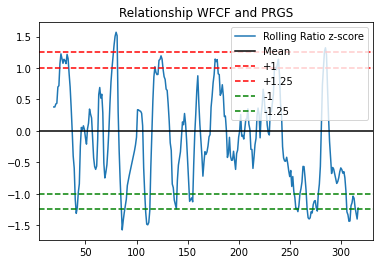

In [17]:
df = dfList[0]['df']

plot_data(df)

In [18]:
dfList

[{'signal': 'Buy',
  'df':          index       WFCF       PRGS     ratio    zscore     mavg5    mavg20  \
  0   2020-08-05  24.235689  36.347748  0.666773  1.041647       NaN       NaN   
  1   2020-08-06  22.176447  36.121498  0.613940  0.805193       NaN       NaN   
  2   2020-08-07  24.077286  36.288731  0.663492  1.026964       NaN       NaN   
  3   2020-08-10  24.235689  36.190357  0.669673  1.054625       NaN       NaN   
  4   2020-08-11  23.126867  35.905087  0.644111  0.940224  0.651598       NaN   
  ..         ...        ...        ...       ...       ...       ...       ...   
  313 2021-11-01  12.340000  52.119999  0.236761 -0.882890  0.246122  0.259352   
  314 2021-11-02  12.390000  51.930000  0.238590 -0.874703  0.242064  0.257975   
  315 2021-11-03  12.750000  52.340000  0.243600 -0.852285  0.239486  0.256660   
  316 2021-11-04  11.560000  52.200001  0.221456 -0.951390  0.233637  0.253926   
  317 2021-11-05  11.699900  52.240002  0.223964 -0.940163  0.232874  0.2